# Kodai Senga: MLB Pitching Analysis (2023-2025)

**メッツ千賀滉大の「お化けフォーク」と故障からの復帰を追う**

- 2023（ルーキー年・フル稼働）vs 2024（故障離脱）vs 2025前半（好調・ERA 1.47）vs 2025後半（故障復帰後・不振）
- 2025/6/12 ナショナルズ戦でハムストリング負傷 → 約1ヶ月IL → 7月復帰後に大幅不振
- お化けフォーク（FO）の変化量・空振り率・ゾーン分析
- 球種配分の変化
- 球速・スピンレートの推移
- 2ストライク時の決め球戦略

---

In [1]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher
import duckdb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# ====== Settings ======
PITCHER_ID = 673540  # Kodai Senga MLBAM ID
YEARS = [2023, 2024, 2025]
GAME_TYPE = 'R'  # Regular season only

# 2025 injury split: hamstring strain on June 12 vs Nationals
# IL ~1 month, returned ~July 11
INJURY_DATE = '2025-06-13'  # Games before this = pre-injury, after = post-injury
# ======================

## 1. Data Acquisition

※ 2024年は故障で登板数が極端に少ない可能性あり
※ 2025年は6/12ハムストリング負傷を境に前半(好調)・後半(不振)に分割

In [3]:
dfs = []
for year in YEARS:
    print(f'Fetching {year}...')
    df_year = statcast_pitcher(f'{year}-03-01', f'{year}-12-31', PITCHER_ID)
    df_year['season'] = year
    dfs.append(df_year)
    print(f'  {year}: {len(df_year):,} pitches')

df_raw = pd.concat(dfs, ignore_index=True)
print(f'\nTotal (raw): {len(df_raw):,} pitches')

# Filter regular season only + split 2025 into pre/post injury
con = duckdb.connect()
df = con.execute(f"""
    SELECT *,
        CASE
            WHEN season = 2023 THEN '2023'
            WHEN season = 2024 THEN '2024'
            WHEN season = 2025 AND game_date < '{INJURY_DATE}' THEN '2025-Pre'
            ELSE '2025-Post'
        END as period
    FROM df_raw
    WHERE game_type = '{GAME_TYPE}'
""").df()

print(f'Total (regular season): {len(df):,} pitches')
print(f'\nPeriod breakdown:')
PERIODS = []
for p in ['2023', '2024', '2025-Pre', '2025-Post']:
    n = len(df[df['period'] == p])
    if n > 0:
        PERIODS.append(p)
        label = {
            '2023': '2023 (Rookie, full season)',
            '2024': '2024 (Injury year, limited)',
            '2025-Pre': '2025-Pre (Before 6/12 injury, ERA ~1.47)',
            '2025-Post': '2025-Post (After ~7/11 return, struggled)'
        }.get(p, p)
        print(f'  {label}: {n:,} pitches')

if '2024' in PERIODS and len(df[df['period'] == '2024']) < 100:
    print('\n⚠️ 2024 data is very limited (injury year). Some analyses may skip 2024.')

Fetching 2023...
Gathering Player Data
  2023: 2,951 pitches
Fetching 2024...
Gathering Player Data
  2024: 169 pitches
Fetching 2025...
Gathering Player Data
  2025: 2,052 pitches

Total (raw): 5,172 pitches
Total (regular season): 4,784 pitches

Period breakdown:
  2023 (Rookie, full season): 2,803 pitches
  2024 (Injury year, limited): 73 pitches
  2025-Pre (Before 6/12 injury, ERA ~1.47): 1,180 pitches
  2025-Post (After ~7/11 return, struggled): 728 pitches

⚠️ 2024 data is very limited (injury year). Some analyses may skip 2024.


## 2. Data Summary

In [4]:
summary = con.execute("""
    SELECT
        period,
        COUNT(*) as pitches,
        COUNT(DISTINCT game_date) as games,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(MAX(release_speed), 1) as max_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(DISTINCT pitch_type) as pitch_types
    FROM df
    GROUP BY period
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END
""").df()

print('=== Season Overview ===')
print(summary.to_string(index=False))
print(f'\nTotal: {len(df):,} pitches')

=== Season Overview ===
   period  pitches  games  avg_velo  max_velo  avg_spin  pitch_types
     2023     2803     29      89.4      99.8    2094.0            6
     2024       73      1      89.2      98.4    2025.0            6
 2025-Pre     1180     13      87.9      98.3    2051.0            8
2025-Post      728      9      87.5      97.9    2090.0            8

Total: 4,784 pitches


## 3. Pitch Arsenal Overview

In [5]:
arsenal = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        ROUND(AVG(pfx_x * 12), 1) as h_break_in,
        ROUND(AVG(pfx_z * 12), 1) as v_break_in
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, count DESC
""").df()

print('=== Pitch Arsenal by Period ===')
for period in PERIODS:
    data = arsenal[arsenal['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'count', 'pct', 'avg_velo', 'avg_spin', 'h_break_in', 'v_break_in']].to_string(index=False))

=== Pitch Arsenal by Period ===

--- 2023 ---
pitch_type  count  pct  avg_velo  avg_spin  h_break_in  v_break_in
        FF   1033 37.0      95.7    2283.0        -8.0        16.6
        FC    699 25.0      90.8    2498.0         0.6         9.8
        FO    664 23.8      83.2    1118.0        -7.2         1.9
        ST    165  5.9      80.8    2578.0        12.4        -3.1
        SL    161  5.8      84.6    2483.0         1.7         1.4
        CU     73  2.6      72.7    2492.0         3.5       -11.2

--- 2024 ---
pitch_type  count  pct  avg_velo  avg_spin  h_break_in  v_break_in
        FF     29 39.7      95.8    2349.0        -7.6        17.2
        FO     24 32.9      83.1    1188.0        -7.4         1.1
        FC     12 16.4      91.9    2553.0        -0.3        10.2
        ST      5  6.8      79.4    2602.0        11.9        -4.2
        SL      2  2.7      84.8    2508.0         1.3        -1.4
        CU      1  1.4      70.8    2505.0         5.2       -16.8

-

## 4. Pitch Mix Evolution

故障前後で球種の使い分けがどう変わったか（特に2025前半 vs 後半の差に注目）

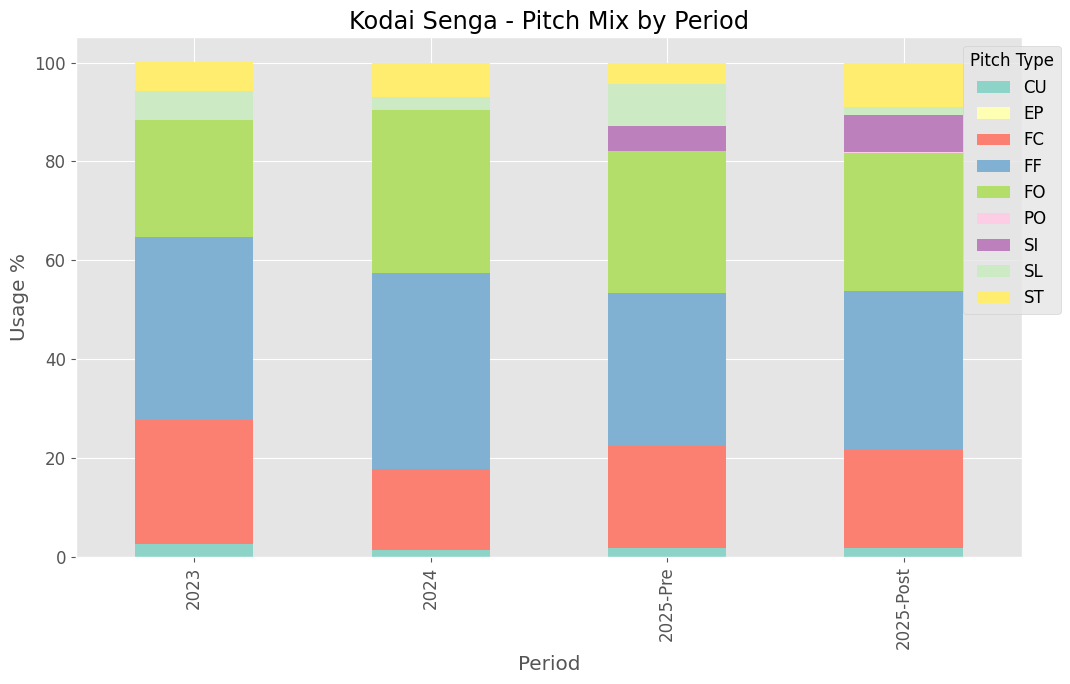


=== Pitch Mix (% usage) ===
pitch_type   CU   EP    FC    FF    FO   PO   SI   SL   ST
period                                                    
2023        2.6  0.0  25.0  37.0  23.8  0.0  0.0  5.8  5.9
2024        1.4  0.0  16.4  39.7  32.9  0.0  0.0  2.7  6.8
2025-Pre    1.7  0.1  20.6  31.0  28.7  0.0  5.0  8.5  4.4
2025-Post   1.7  0.0  19.8  32.3  27.9  0.1  7.6  1.7  8.9

=== 2023 → 2025-Pre (healthy baseline comparison) ===
  FF: 37.0% → 31.0% (↓6.0%)
  FC: 25.0% → 20.6% (↓4.4%)
  ST: 5.9% → 4.4% (↓1.5%)
  SL: 5.8% → 8.5% (↑2.7%)
  FO: 23.8% → 28.7% (↑4.9%)
  SI: 0.0% → 5.0% (↑5.0%)

=== 2025-Pre → 2025-Post (injury impact) ===
  SL: 8.5% → 1.7% (↓6.8%)
  FF: 31.0% → 32.3% (↑1.3%)
  SI: 5.0% → 7.6% (↑2.6%)
  ST: 4.4% → 8.9% (↑4.5%)


In [6]:
mix_pivot = arsenal.pivot_table(index='period', columns='pitch_type', values='pct', fill_value=0)
mix_pivot = mix_pivot.reindex(PERIODS)

mix_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')
plt.title('Kodai Senga - Pitch Mix by Period')
plt.xlabel('Period')
plt.ylabel('Usage %')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Pitch Mix (% usage) ===')
print(mix_pivot.round(1).to_string())

# Compare key period pairs
comparisons = [
    ('2023', '2025-Pre', '2023 → 2025-Pre (healthy baseline comparison)'),
    ('2025-Pre', '2025-Post', '2025-Pre → 2025-Post (injury impact)'),
]
for p1, p2, label in comparisons:
    if p1 in mix_pivot.index and p2 in mix_pivot.index:
        first = mix_pivot.loc[p1]
        last = mix_pivot.loc[p2]
        diff = (last - first).sort_values()
        print(f'\n=== {label} ===')
        for pitch, change in diff.items():
            if abs(change) >= 1.0:
                direction = '↑' if change > 0 else '↓'
                print(f'  {pitch}: {first[pitch]:.1f}% → {last[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

## 5. Velocity Trends by Period

2025前半（好調）と後半（不振）で球速に差はあるか

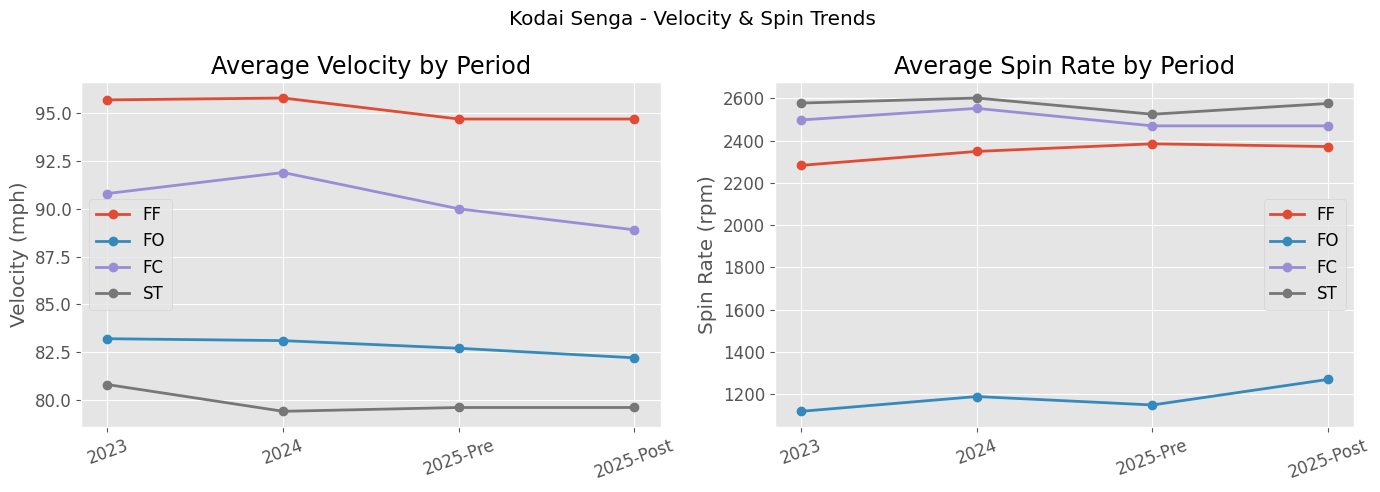


=== Velocity & Spin by Period (Top Pitches) ===

FF:
   period  avg_velo  avg_spin  count
     2023      95.7    2283.0   1033
     2024      95.8    2349.0     29
2025-Post      94.7    2372.0    235
 2025-Pre      94.7    2385.0    364

FO:
   period  avg_velo  avg_spin  count
     2023      83.2    1118.0    664
     2024      83.1    1188.0     24
2025-Post      82.2    1269.0    203
 2025-Pre      82.7    1148.0    337

FC:
   period  avg_velo  avg_spin  count
     2023      90.8    2498.0    699
     2024      91.9    2553.0     12
2025-Post      88.9    2470.0    144
 2025-Pre      90.0    2470.0    242

ST:
   period  avg_velo  avg_spin  count
     2023      80.8    2578.0    165
     2024      79.4    2602.0      5
2025-Post      79.6    2576.0     65
 2025-Pre      79.6    2525.0     52


In [7]:
velo_by_period = con.execute("""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(*) as count
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period
""").df()

top_pitches = con.execute("""
    SELECT pitch_type FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY pitch_type
    ORDER BY COUNT(*) DESC
    LIMIT 4
""").df()['pitch_type'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

period_order = {p: i for i, p in enumerate(PERIODS)}
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch].copy()
    data['period_idx'] = data['period'].map(period_order)
    data = data.dropna(subset=['period_idx']).sort_values('period_idx')
    if len(data) > 0:
        axes[0].plot(data['period'], data['avg_velo'], marker='o', label=pitch, linewidth=2)
        axes[1].plot(data['period'], data['avg_spin'], marker='o', label=pitch, linewidth=2)

axes[0].set_title('Average Velocity by Period')
axes[0].set_ylabel('Velocity (mph)')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=20)

axes[1].set_title('Average Spin Rate by Period')
axes[1].set_ylabel('Spin Rate (rpm)')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('Kodai Senga - Velocity & Spin Trends')
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Velocity & Spin by Period (Top Pitches) ===')
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch]
    print(f'\n{pitch}:')
    print(data[['period', 'avg_velo', 'avg_spin', 'count']].to_string(index=False))

## 5.5. Monthly Velocity & xwOBA Trend (2025 Focus)

2025年の月別推移で、故障前の好調と復帰後の不振を細かく確認

In [8]:
# Monthly trends for 2025 (and 2023 for comparison)
monthly = con.execute("""
    SELECT
        season,
        EXTRACT(MONTH FROM game_date) as month,
        COUNT(*) as pitches,
        COUNT(DISTINCT game_date) as games,
        ROUND(AVG(CASE WHEN pitch_type = 'FF' THEN release_speed END), 1) as ff_velo,
        ROUND(AVG(CASE WHEN pitch_type = 'FO' THEN release_speed END), 1) as fo_velo,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(AVG(CASE WHEN launch_speed IS NOT NULL THEN estimated_woba_using_speedangle END), 3) as avg_xwOBA
    FROM df
    WHERE season IN (2023, 2025)
    GROUP BY season, month
    HAVING COUNT(*) >= 30
    ORDER BY season, month
""").df()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for year in [2023, 2025]:
    data = monthly[monthly['season'] == year]
    label = str(year)
    axes[0][0].plot(data['month'], data['ff_velo'], marker='o', label=label, linewidth=2)
    axes[0][1].plot(data['month'], data['fo_velo'], marker='o', label=label, linewidth=2)
    axes[1][0].plot(data['month'], data['whiff_rate'], marker='o', label=label, linewidth=2)
    axes[1][1].plot(data['month'], data['avg_xwOBA'], marker='o', label=label, linewidth=2)

# Add injury marker for 2025
for ax in axes.flat:
    ax.axvline(x=6.5, color='red', linestyle='--', alpha=0.6, label='6/12 Injury')
    ax.set_xticks(range(3, 11))
    ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    ax.legend(fontsize=9)

axes[0][0].set_title('FF Velocity (mph)')
axes[0][1].set_title('FO (Ghost Fork) Velocity (mph)')
axes[1][0].set_title('Overall Whiff Rate (%)')
axes[1][1].set_title('xwOBA Allowed (lower = better)')

plt.suptitle('Kodai Senga - Monthly Trends (2023 vs 2025)', fontsize=14)
plt.tight_layout()
plt.show()

# === Text Summary ===
print('=== Monthly Trends ===')
for year in [2023, 2025]:
    data = monthly[monthly['season'] == year]
    print(f'\n--- {year} ---')
    print(data[['month', 'games', 'pitches', 'ff_velo', 'fo_velo', 'whiff_rate', 'avg_xwOBA']].to_string(index=False))

BinderException: Binder Error: No function matches the given name and argument types 'date_part(STRING_LITERAL, VARCHAR)'. You might need to add explicit type casts.
	Candidate functions:
	date_part(VARCHAR[], DATE) -> STRUCT()
	date_part(VARCHAR[], INTERVAL) -> STRUCT()
	date_part(VARCHAR[], TIME) -> STRUCT()
	date_part(VARCHAR[], TIMESTAMP) -> STRUCT()
	date_part(VARCHAR[], TIME WITH TIME ZONE) -> STRUCT()
	date_part(VARCHAR, DATE) -> BIGINT
	date_part(VARCHAR, INTERVAL) -> BIGINT
	date_part(VARCHAR, TIME) -> BIGINT
	date_part(VARCHAR, TIMESTAMP) -> BIGINT
	date_part(VARCHAR, TIME WITH TIME ZONE) -> BIGINT
	date_part(VARCHAR[], TIMESTAMP WITH TIME ZONE) -> STRUCT()
	date_part(VARCHAR, TIMESTAMP WITH TIME ZONE) -> BIGINT


LINE 4:         EXTRACT(MONTH FROM game_date) as month,
                ^

## 6. Fatigue Pattern: Inning-by-Inning Velocity

2023(フル稼働) vs 2025-Pre(好調) vs 2025-Post(不振)でスタミナパターンに差はあるか

In [ ]:
ff_type = 'FF' if 'FF' in top_pitches else top_pitches[0]

# Only use periods with enough data
fatigue_periods = [p for p in PERIODS if len(df[df['period'] == p]) >= 200]

fatigue = con.execute(f"""
    SELECT
        period,
        inning,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = '{ff_type}' AND inning <= 8
      AND period IN ({','.join(["'" + p + "'" for p in fatigue_periods])})
    GROUP BY period, inning
    HAVING COUNT(*) >= 5
    ORDER BY period, inning
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
for period in fatigue_periods:
    data = fatigue[fatigue['period'] == period]
    if len(data) > 0:
        ax.plot(data['inning'], data['avg_velo'], marker='o', label=period, linewidth=2)

ax.set_xlabel('Inning')
ax.set_ylabel(f'{ff_type} Velocity (mph)')
ax.set_title(f'Kodai Senga - {ff_type} Velocity by Inning')
ax.set_xticks(range(1, 9))
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print(f'\n=== {ff_type} Velocity by Inning ===')
fatigue_pivot = fatigue.pivot_table(index='inning', columns='period', values='avg_velo')
if len(fatigue_pivot.columns) > 0:
    fatigue_pivot = fatigue_pivot.reindex(columns=[p for p in fatigue_periods if p in fatigue_pivot.columns])
print(fatigue_pivot.to_string())

print(f'\n=== Velocity Drop (1st inning → last inning) ===')
for period in fatigue_periods:
    data = fatigue[fatigue['period'] == period]
    if len(data) >= 2:
        first_velo = data.iloc[0]['avg_velo']
        last_velo = data.iloc[-1]['avg_velo']
        last_inn = int(data.iloc[-1]['inning'])
        drop = last_velo - first_velo
        print(f'  {period}: {first_velo} → {last_velo} (inn {last_inn}) = {drop:+.1f} mph')

## 7. Whiff Rate (空振り率)

空振り率 = 空振り数 / スイング総数

In [ ]:
whiff = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as total_pitches,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) as whiffs,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) as total_swings,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, total_pitches DESC
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
period_order = {p: i for i, p in enumerate(PERIODS)}
for pitch in top_pitches:
    data = whiff[whiff['pitch_type'] == pitch].copy()
    data['period_idx'] = data['period'].map(period_order)
    data = data.dropna(subset=['period_idx']).sort_values('period_idx')
    if len(data) > 0:
        ax.plot(data['period'], data['whiff_rate'], marker='o', label=pitch, linewidth=2)

ax.set_ylabel('Whiff Rate (%)')
ax.set_title('Kodai Senga - Whiff Rate by Pitch Type')
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Whiff Rate by Pitch Type ===')
whiff_pivot = whiff.pivot_table(index='pitch_type', columns='period', values='whiff_rate')
if len(whiff_pivot.columns) > 0:
    whiff_pivot = whiff_pivot.reindex(columns=PERIODS)
print(whiff_pivot.round(1).to_string())

## 8. Two-Strike Strategy

2ストライクからの「決め球」がどう変わったか（お化けフォークの出番は？）

In [ ]:
two_strike = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE strikes = 2 AND pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, pitches DESC
""").df()

print('=== Two-Strike Pitch Selection ===')
for period in PERIODS:
    data = two_strike[two_strike['period'] == period].head(6)
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'pitches', 'pct', 'whiff_rate']].to_string(index=False))

## 9. Count Situation Analysis

有利/不利カウントでの球種配分

In [ ]:
count_analysis = con.execute("""
    SELECT
        period,
        CASE
            WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
            WHEN balls > strikes THEN 'Behind'
            WHEN strikes > balls THEN 'Ahead'
            ELSE 'Even'
        END as count_situation,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(
            PARTITION BY period,
            CASE
                WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
                WHEN balls > strikes THEN 'Behind'
                WHEN strikes > balls THEN 'Ahead'
                ELSE 'Even'
            END
        ), 1) as pct
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, count_situation, pitch_type
    ORDER BY period, count_situation, pitches DESC
""").df()

print('=== Pitch Selection by Count Situation ===')
for period in PERIODS:
    print(f'\n=== {period} ===')
    for situation in ['Ahead', 'Even', 'Behind', 'Full Count']:
        data = count_analysis[
            (count_analysis['period'] == period) &
            (count_analysis['count_situation'] == situation)
        ].head(4)
        if len(data) > 0:
            top_str = ', '.join([f"{r['pitch_type']} {r['pct']}%" for _, r in data.iterrows()])
            print(f'  {situation}: {top_str}')

## 10. Batted Ball Results (被打球)

打たれた時の結果をシーズン別に比較

In [ ]:
batted = con.execute("""
    SELECT
        period,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(launch_angle), 1) as avg_launch_angle,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM df
    WHERE launch_speed IS NOT NULL
    GROUP BY period
    ORDER BY period
""").df()

print('=== Batted Ball Results by Season ===')
print(batted.to_string(index=False))

# By pitch type
batted_by_pitch = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA
    FROM df
    WHERE launch_speed IS NOT NULL AND pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 5
    ORDER BY period, batted_balls DESC
""").df()

print('\n=== Batted Ball by Pitch Type (min 5 BIP) ===')
for period in PERIODS:
    data = batted_by_pitch[batted_by_pitch['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'batted_balls', 'avg_exit_velo', 'avg_xBA']].to_string(index=False))

## 11. Ghost Fork Deep Dive（お化けフォーク徹底分析）

千賀の代名詞「お化けフォーク」（Statcast分類: **FO = Forkball**）を多角的に分析

- 変化量（水平・垂直）の比較
- ゾーン別の空振り率・スイング率
- 位置分布（ストライクゾーン vs ボールゾーン）
- カウント別使用率
- FF vs FO リリースポイント比較（トンネル効果）

In [ ]:
# Ghost Fork (FO) movement profile
fs_movement = con.execute("""
    SELECT
        period,
        COUNT(*) as pitches,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        ROUND(AVG(pfx_x * 12), 1) as h_break_in,
        ROUND(AVG(pfx_z * 12), 1) as v_break_in,
        ROUND(STDDEV(pfx_x * 12), 1) as h_break_std,
        ROUND(STDDEV(pfx_z * 12), 1) as v_break_std
    FROM df
    WHERE pitch_type = 'FO'
    GROUP BY period
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END
""").df()

print('=== Ghost Fork (FO) Movement Profile ===')
print(fs_movement.to_string(index=False))
print('\n(h_break_in: horizontal break in inches, negative = glove-side for RHP)')
print('(v_break_in: induced vertical break in inches)')

# Movement scatter plot by period
plot_periods = [p for p in PERIODS if len(df[(df['period'] == p) & (df['pitch_type'] == 'FO')]) > 0]
fig, axes = plt.subplots(1, len(plot_periods), figsize=(5 * len(plot_periods), 5))
if len(plot_periods) == 1:
    axes = [axes]

for i, period in enumerate(plot_periods):
    fo_data = con.execute(f"""
        SELECT pfx_x * 12 as h_break, pfx_z * 12 as v_break
        FROM df
        WHERE pitch_type = 'FO' AND period = '{period}'
          AND pfx_x IS NOT NULL AND pfx_z IS NOT NULL
    """).df()

    if len(fo_data) > 0:
        axes[i].scatter(fo_data['h_break'], fo_data['v_break'], alpha=0.3, s=20, c='purple')
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_xlim(-25, 25)
        axes[i].set_ylim(-25, 25)
        axes[i].set_xlabel('Horizontal Break (in)')
        axes[i].set_ylabel('Induced Vertical Break (in)')
        axes[i].set_title(f'FO Movement - {period} (n={len(fo_data)})')
        axes[i].set_aspect('equal')

plt.suptitle('Kodai Senga - Ghost Fork (FO) Movement Profile')
plt.tight_layout()
plt.show()

In [ ]:
# Ghost Fork (FO) zone analysis
# zone 1-9 = strike zone, 11-14 = chase/waste zones
fs_zone = con.execute("""
    SELECT
        period,
        CASE
            WHEN zone BETWEEN 1 AND 9 THEN 'In Zone'
            WHEN zone BETWEEN 11 AND 14 THEN 'Chase'
            ELSE 'Waste'
        END as zone_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) / COUNT(*), 1) as swing_rate
    FROM df
    WHERE pitch_type = 'FO' AND zone IS NOT NULL
    GROUP BY period, zone_type
    ORDER BY period, zone_type
""").df()

print('=== Ghost Fork (FO) Zone Analysis ===')
for period in PERIODS:
    data = fs_zone[fs_zone['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ---')
        print(data[['zone_type', 'pitches', 'pct', 'swing_rate', 'whiff_rate']].to_string(index=False))

In [ ]:
# Ghost Fork (FO) location scatter by period
plot_periods = [p for p in PERIODS if len(df[(df['period'] == p) & (df['pitch_type'] == 'FO')]) > 0]
fig, axes = plt.subplots(1, len(plot_periods), figsize=(5 * len(plot_periods), 6))
if len(plot_periods) == 1:
    axes = [axes]

for i, period in enumerate(plot_periods):
    fo_loc = con.execute(f"""
        SELECT plate_x, plate_z, description
        FROM df
        WHERE pitch_type = 'FO' AND period = '{period}'
          AND plate_x IS NOT NULL AND plate_z IS NOT NULL
    """).df()

    if len(fo_loc) > 0:
        whiff_mask = fo_loc['description'].isin(['swinging_strike', 'swinging_strike_blocked'])

        axes[i].scatter(fo_loc[~whiff_mask]['plate_x'], fo_loc[~whiff_mask]['plate_z'],
                        alpha=0.3, s=20, c='gray', label='Other')
        axes[i].scatter(fo_loc[whiff_mask]['plate_x'], fo_loc[whiff_mask]['plate_z'],
                        alpha=0.7, s=30, c='red', label='Whiff')

        # Strike zone box (approximate)
        axes[i].plot([-0.83, 0.83, 0.83, -0.83, -0.83],
                     [1.5, 1.5, 3.5, 3.5, 1.5], 'k-', linewidth=1)
        axes[i].set_xlim(-2.5, 2.5)
        axes[i].set_ylim(0, 5)
        axes[i].set_title(f'FO Location - {period} (n={len(fo_loc)})')
        axes[i].set_xlabel('Plate X')
        axes[i].set_ylabel('Plate Z')
        axes[i].legend(fontsize=8)
        axes[i].set_aspect('equal')

plt.suptitle('Kodai Senga - Ghost Fork (FO) Location by Period')
plt.tight_layout()
plt.show()

# Average FO location
fo_location = con.execute("""
    SELECT
        period,
        ROUND(AVG(plate_x), 2) as avg_plate_x,
        ROUND(AVG(plate_z), 2) as avg_plate_z,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = 'FO' AND plate_x IS NOT NULL
    GROUP BY period
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END
""").df()

print('\n=== Ghost Fork (FO) Average Location ===')
print(fo_location.to_string(index=False))

In [ ]:
# Ghost Fork (FO) usage by count
fo_by_count = con.execute("""
    SELECT
        period,
        balls || '-' || strikes as count,
        ROUND(100.0 * SUM(CASE WHEN pitch_type = 'FO' THEN 1 ELSE 0 END) / COUNT(*), 1) as fo_pct,
        SUM(CASE WHEN pitch_type = 'FO' THEN 1 ELSE 0 END) as fo_count,
        COUNT(*) as total
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, balls, strikes
    HAVING COUNT(*) >= 10
    ORDER BY period, balls, strikes
""").df()

print('=== Ghost Fork (FO) Usage % by Count ===')
for period in PERIODS:
    data = fo_by_count[fo_by_count['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ---')
        print(data[['count', 'fo_pct', 'fo_count', 'total']].to_string(index=False))

In [ ]:
# FF vs FO Release Point Comparison (Tunnel Effect)
# お化けフォークが効く理由 = FFと見分けがつかない
# 故障後にリリースポイントがズレたか確認
release = con.execute("""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(release_pos_x), 2) as avg_rel_x,
        ROUND(AVG(release_pos_z), 2) as avg_rel_z,
        ROUND(STDDEV(release_pos_x), 2) as std_rel_x,
        ROUND(STDDEV(release_pos_z), 2) as std_rel_z,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type IN ('FF', 'FO')
      AND release_pos_x IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END, pitch_type
""").df()

print('=== FF vs FO Release Point ===')
print(release.to_string(index=False))

# Calculate FF-FO release point gap per period
print('\n=== FF-FO Release Point Gap (smaller = harder to distinguish) ===')
for period in PERIODS:
    ff = release[(release['period'] == period) & (release['pitch_type'] == 'FF')]
    fo = release[(release['period'] == period) & (release['pitch_type'] == 'FO')]
    if len(ff) > 0 and len(fo) > 0:
        dx = abs(ff.iloc[0]['avg_rel_x'] - fo.iloc[0]['avg_rel_x'])
        dz = abs(ff.iloc[0]['avg_rel_z'] - fo.iloc[0]['avg_rel_z'])
        velo_gap = ff.iloc[0]['avg_velo'] - fo.iloc[0]['avg_velo']
        print(f'  {period}: X gap={dx:.2f}in, Z gap={dz:.2f}in, Velo gap={velo_gap:.1f}mph')

# Scatter plot
plot_periods = [p for p in PERIODS if len(df[df['period'] == p]) >= 50]
fig, axes = plt.subplots(1, len(plot_periods), figsize=(5 * len(plot_periods), 5))
if len(plot_periods) == 1:
    axes = [axes]

for i, period in enumerate(plot_periods):
    for pt, color, label in [('FF', 'red', 'FF'), ('FO', 'purple', 'FO (Ghost Fork)')]:
        pt_data = con.execute(f"""
            SELECT release_pos_x, release_pos_z
            FROM df
            WHERE pitch_type = '{pt}' AND period = '{period}'
              AND release_pos_x IS NOT NULL
        """).df()
        if len(pt_data) > 0:
            axes[i].scatter(pt_data['release_pos_x'], pt_data['release_pos_z'],
                            alpha=0.2, s=15, c=color, label=f'{label} ({len(pt_data)})')
    axes[i].set_xlabel('Release Pos X (ft)')
    axes[i].set_ylabel('Release Pos Z (ft)')
    axes[i].set_title(f'{period}')
    axes[i].legend(fontsize=8)

plt.suptitle('FF vs FO Release Point - Can Batters Tell Them Apart?')
plt.tight_layout()
plt.show()

## 12. All Pitch Movement Comparison

全球種の変化量を1つのチャートで比較（お化けフォークの特異性を視覚化）

In [ ]:
# All pitches movement scatter by season
fig, axes = plt.subplots(1, len(PERIODS), figsize=(6 * len(PERIODS), 6))
if len(PERIODS) == 1:
    axes = [axes]

colors = {'FF': 'red', 'FO': 'purple', 'SL': 'blue', 'CU': 'green',
          'CH': 'orange', 'FC': 'brown', 'SI': 'pink', 'ST': 'cyan',
          'KC': 'darkgreen', 'CS': 'olive', 'FS': 'magenta'}

for i, period in enumerate(PERIODS):
    all_movement = con.execute(f"""
        SELECT pitch_type, pfx_x * 12 as h_break, pfx_z * 12 as v_break
        FROM df
        WHERE period = '{period}'
          AND pfx_x IS NOT NULL AND pfx_z IS NOT NULL
          AND pitch_type IS NOT NULL
    """).df()

    for pitch_type in all_movement['pitch_type'].unique():
        pt_data = all_movement[all_movement['pitch_type'] == pitch_type]
        c = colors.get(pitch_type, 'gray')
        axes[i].scatter(pt_data['h_break'], pt_data['v_break'],
                        alpha=0.2, s=15, c=c, label=f'{pitch_type} ({len(pt_data)})')

    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[i].set_xlim(-25, 25)
    axes[i].set_ylim(-25, 25)
    axes[i].set_xlabel('Horizontal Break (in)')
    axes[i].set_ylabel('Induced Vertical Break (in)')
    axes[i].set_title(f'{period}')
    axes[i].legend(fontsize=7, loc='upper left')
    axes[i].set_aspect('equal')

plt.suptitle('Kodai Senga - All Pitch Movement by Period')
plt.tight_layout()
plt.show()

# === Text Summary: average movement by pitch type ===
all_avg_movement = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(AVG(pfx_x * 12), 1) as h_break_in,
        ROUND(AVG(pfx_z * 12), 1) as v_break_in
    FROM df
    WHERE pfx_x IS NOT NULL AND pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END, pitches DESC
""").df()

print('\n=== Average Movement by Pitch Type (min 10 pitches) ===')
for period in PERIODS:
    data = all_avg_movement[all_avg_movement['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'pitches', 'h_break_in', 'v_break_in']].to_string(index=False))

## 13. Left/Right Batter Splits (左右別)

お化けフォークの左右別効果を確認

In [ ]:
# L/R splits - pitch usage and effectiveness
lr_arsenal = con.execute("""
    SELECT
        period,
        stand,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period, stand), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, stand, pitch_type
    HAVING COUNT(*) >= 5
    ORDER BY period, stand, count DESC
""").df()

print('=== Pitch Usage & Whiff Rate by Batter Side ===')
for period in PERIODS:
    print(f'\n=== {period} ===')
    for side in ['L', 'R']:
        data = lr_arsenal[(lr_arsenal['period'] == period) & (lr_arsenal['stand'] == side)]
        print(f'\n  vs {side}HB:')
        print(data[['pitch_type', 'count', 'pct', 'whiff_rate']].to_string(index=False))

# FO-specific L/R splits
lr_fo = con.execute("""
    SELECT
        period,
        stand,
        COUNT(*) as pitches,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(AVG(CASE WHEN launch_speed IS NOT NULL THEN estimated_ba_using_speedangle END), 3) as xBA_on_contact
    FROM df
    WHERE pitch_type = 'FO'
    GROUP BY period, stand
    ORDER BY CASE period
        WHEN '2023' THEN 1 WHEN '2024' THEN 2
        WHEN '2025-Pre' THEN 3 WHEN '2025-Post' THEN 4
    END, stand
""").df()

print('\n=== Ghost Fork (FO) Left/Right Splits ===')
print(lr_fo.to_string(index=False))

## 14. Time Through Order (打順周り別)

1巡目/2巡目/3巡目で打たれ方の変化 → お化けフォークは2巡目以降もキレているか

In [ ]:
# Only use seasons with enough data
tto_periods = [p for p in PERIODS if len(df[df['period'] == p]) >= 200]

tto = con.execute(f"""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        WHERE period IN ({','.join(["'" + p + "'" for p in tto_periods])})
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
        WHERE d.period IN ({','.join(["'" + p + "'" for p in tto_periods])})
    )
    SELECT
        period,
        tto,
        COUNT(*) as pitches,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM tto_tagged
    GROUP BY period, tto
    ORDER BY period, tto
""").df()

print('=== Whiff Rate by Time Through Order ===')
if len(tto) > 0:
    tto_pivot = tto.pivot_table(index='tto', columns='period', values='whiff_rate')
    tto_pivot = tto_pivot.reindex(columns=[p for p in tto_periods if p in tto_pivot.columns])
    print(tto_pivot.round(1).to_string())

# TTO with FO specifically
tto_fo = con.execute(f"""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        WHERE period IN ({','.join(["'" + p + "'" for p in tto_periods])})
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
        WHERE d.period IN ({','.join(["'" + p + "'" for p in tto_periods])})
    )
    SELECT
        period,
        tto,
        SUM(CASE WHEN pitch_type = 'FO' THEN 1 ELSE 0 END) as fo_pitches,
        COUNT(*) as total_pitches,
        ROUND(100.0 * SUM(CASE WHEN pitch_type = 'FO' THEN 1 ELSE 0 END) / COUNT(*), 1) as fo_pct,
        ROUND(100.0 * SUM(CASE WHEN pitch_type = 'FO' AND description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN pitch_type = 'FO' AND description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as fo_whiff_rate
    FROM tto_tagged
    WHERE pitch_type IS NOT NULL
    GROUP BY period, tto
    ORDER BY period, tto
""").df()

print('\n=== Ghost Fork (FO) by Time Through Order ===')
for period in tto_periods:
    data = tto_fo[tto_fo['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['tto', 'fo_pitches', 'fo_pct', 'fo_whiff_rate']].to_string(index=False))

## 15. Summary

In [ ]:
print('=' * 60)
print('KODAI SENGA 2023-2025 ANALYSIS SUMMARY')
print('=' * 60)

# Games & Pitches
print('\n[Workload]')
for _, row in summary.iterrows():
    print(f'  {row["period"]}: {int(row["games"])} games, {int(row["pitches"]):,} pitches, avg {row["avg_velo"]} mph')

# Pitch mix changes (2025-Pre vs 2025-Post focus)
print(f'\n[Pitch Mix Changes: 2025 Pre vs Post Injury]')
if '2025-Pre' in mix_pivot.index and '2025-Post' in mix_pivot.index:
    pre = mix_pivot.loc['2025-Pre']
    post = mix_pivot.loc['2025-Post']
    diff = (post - pre).sort_values()
    for pitch, change in diff.items():
        if abs(change) >= 1.0:
            direction = '↑' if change > 0 else '↓'
            print(f'  {pitch}: {pre[pitch]:.1f}% → {post[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

# Pitch mix changes (2023 vs 2025-Pre)
print(f'\n[Pitch Mix Changes: 2023 Rookie vs 2025-Pre]')
if '2023' in mix_pivot.index and '2025-Pre' in mix_pivot.index:
    base = mix_pivot.loc['2023']
    pre = mix_pivot.loc['2025-Pre']
    diff = (pre - base).sort_values()
    for pitch, change in diff.items():
        if abs(change) >= 1.0:
            direction = '↑' if change > 0 else '↓'
            print(f'  {pitch}: {base[pitch]:.1f}% → {pre[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

# Velocity
print(f'\n[Fastball Velocity]')
ff_data = velo_by_period[velo_by_period['pitch_type'] == 'FF']
for _, row in ff_data.iterrows():
    if row['period'] in PERIODS:
        print(f'  {row["period"]}: {row["avg_velo"]} mph ({int(row["count"])} pitches)')

# Ghost Fork (FO)
print(f'\n[Ghost Fork (FO)]')
if len(fs_movement) > 0:
    for _, row in fs_movement.iterrows():
        print(f'  {row["period"]}: {row["avg_velo"]} mph, H-break {row["h_break_in"]}in, V-break {row["v_break_in"]}in ({int(row["pitches"])} pitches)')
else:
    print('  No FO data found')

# Best whiff pitch per period
print(f'\n[Best Whiff Rate Pitch]')
for period in PERIODS:
    period_whiff = whiff[(whiff['period'] == period) & (whiff['total_swings'] >= 20)]
    if len(period_whiff) > 0:
        best = period_whiff.loc[period_whiff['whiff_rate'].idxmax()]
        print(f'  {period}: {best["pitch_type"]} ({best["whiff_rate"]}%)')

# Batted ball
print(f'\n[Batted Ball Quality]')
for _, row in batted.iterrows():
    print(f'  {row["period"]}: xwOBA {row["avg_xwOBA"]}, Hard Hit {row["hard_hit_pct"]}%, Exit Velo {row["avg_exit_velo"]} mph')

# Key narrative
print(f'\n[Key Question: What changed after the injury?]')
print('  Compare 2025-Pre vs 2025-Post across all metrics above.')
print('  Was it velocity? Movement? Pitch selection? Command?')
print('  Did the FF-FO tunnel effect break down?')

print('\n' + '=' * 60)